<a href="https://colab.research.google.com/github/majavk/Data_Science_Portfolio/blob/main/regression_coursera_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Health Insurance costs

## Introduction

The main objective of this project is to optimize for the prediction of results using R2 performance metrics.






The dataset chosen was taken from Kaggle. This dataset is originated from the book
"Machine Learning with R" by Brett Lantz.

\
Columns in the dataset:
*	'age': age of primary beneficiary 
*	'sex': insurance contractor gender, female, male 
*	'bmi': body mass index, providing an understanding of body, weights that are relatively high or low relative to height,
objective index of body weight (kg/m^2) using the ratio of height to weight, ideally 18.5 to 24.9 
*	'children': number of children covered by health insurance/number of dependents
*	'smoker': smoking
*	'region': the beneficiary residential area in the US, northeast, southeast, southwest, northwest.
*	'charges': individual medical costs billed by health insurance

\
The column 'charges' is going to be the target variable. All other columns are going to be the features.




## Setup

In [ ]:
#@title ## Setup: Python modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from scipy import stats
from scipy.stats import f_oneway
from scipy.special import inv_boxcox
import seaborn as sns
from sklearn.linear_model import LinearRegression, Ridge, ElasticNet, Lasso
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
import warnings

In [ ]:
#@title ## Setup: Settings
warnings.filterwarnings("ignore")

In [ ]:
#@title ## Setup: Dataset
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/Colab Notebooks/Coursera/project_1/'
filename = 'insurance.csv'
raw_data = pd.read_csv(path + filename)
df = raw_data.copy()

## Data cleaning

In [ ]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [ ]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [ ]:
#@title ### Checking and dropping duplicates
print(f"Dropped duplicates: {df.duplicated().sum()}")

df = df.drop_duplicates()

Dropped duplicates: 1


In [ ]:
#@title ### Checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

## Data analysis

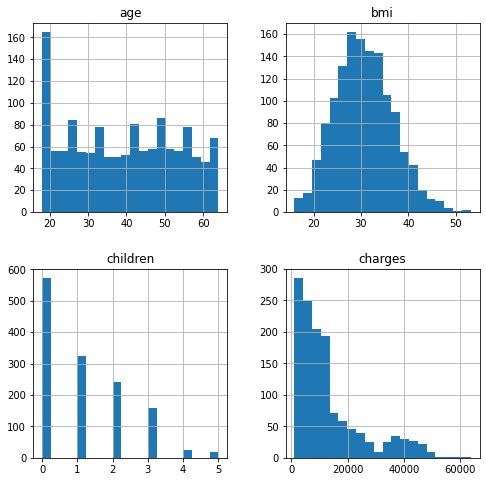

In [ ]:
#@title ### Data columns distributions (numerical type)
df.hist(bins = 20, xlabelsize = 10, ylabelsize = 10, figsize=(8,8))
plt.show()

From these plots it can be seen that the data are not normally distributed.

(Maybe consider applying the yeo johnson transformation to the 'bmi' and charges data columns.)

In [ ]:
#@title ### Checking skewness before and after Yeo-Johnson transformation on the 'bmi' and 'charges' data columns
# list_num = df.select_dtypes(exclude='O').columns.values

skewness_list = list()
skewness_yeo_list = list()
for item in ['bmi', 'charges']:
    skewness_list.append((df[item]).skew())
    pd.Series(stats.yeojohnson(df[item])[0]).skew()
    skewness_yeo_list.append(pd.Series(stats.yeojohnson(df[item])[0]).skew())
    # pd.Series(stats.yeojohnson(df[item])[0]).hist(bins=20, xlabelsize=10, ylabelsize=10, figsize=(3, 6))
    # plt.show()

print(f'The skewness of the "bmi" data column before and after transformation: {round(skewness_list[0], 3)}, {round(skewness_yeo_list[0], 3)}.')
print(f'The skewness of the "charges" data column before and transformation: {round(skewness_list[1], 3)}, {round(skewness_yeo_list[1], 3)}.')

The skewness of the "bmi" data column before and after transformation: 0.284, -0.007.
The skewness of the "charges" data column before and transformation: 1.515, -0.009.


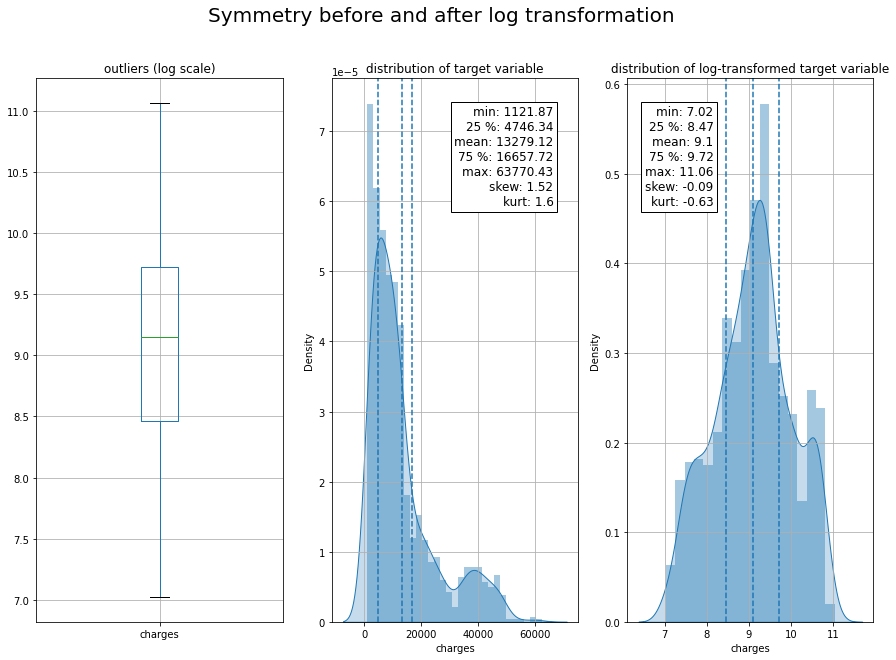

In [ ]:
#@title ### Checking symmetry before and after log transformation on the 'charges' data column
x = "charges"
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,10))
fig.suptitle("Symmetry before and after log transformation", fontsize=20)

### boxplot 
ax[0].title.set_text('outliers (log scale)')
tmp_df_train = pd.DataFrame(df[x])
tmp_df_train[x] = np.log(tmp_df_train[x])
tmp_df_train.boxplot(column=x, ax=ax[0])

### data
ax[1].title.set_text('distribution of target variable')
variable = df[x]

# variable = df_train[x].fillna(df_train[x].mean())  # only if I will plot numerical variable with the missing values
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[(variable > breaks[0]) & (variable < breaks[10])]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[1])
des = df[x].describe()
ax[1].axvline(des["25%"], ls='--')
ax[1].axvline(des["mean"], ls='--')
ax[1].axvline(des["75%"], ls='--')
ax[1].grid(True)

skewness = round(df['charges'].skew(), 2)
kurtosis = round(df['charges'].kurt(), 2)
des = round(des, 2).apply(lambda x: str(x))

box = '\n'.join(("min: "+des["min"], "25 %: "+des["25%"], "mean: "+des["mean"], "75 %: "+des["75%"], "max: "+des["max"], "skew: "+str(skewness), "kurt: "+str(kurtosis)))
ax[1].text(0.90, 0.95, box, transform=ax[1].transAxes, fontsize=12, va='top', ha="right", bbox=dict(boxstyle='square', facecolor='white', alpha=1))

### log transform data
ax[2].title.set_text('distribution of log-transformed target variable')
variable = tmp_df_train[x]

#variable = df_train[x].fillna(df_train[x].mean())  # only if I will plot numerical variable with the missing values
breaks = np.quantile(variable, q=np.linspace(0, 1, 11))
variable = variable[(variable > breaks[0]) & (variable < breaks[10])]

sns.distplot(variable, hist=True, kde=True, kde_kws={"shade": True}, ax=ax[2])
des_log = tmp_df_train[x].describe()

ax[2].axvline(des_log["25%"], ls='--')
ax[2].axvline(des_log["mean"], ls='--')
ax[2].axvline(des_log["75%"], ls='--')
ax[2].grid(True)

skewness = round(tmp_df_train[x].skew(), 2)
kurtosis = round(tmp_df_train[x].kurt(), 2)
des_log = round(des_log, 2).apply(lambda x: str(x))

box = '\n'.join(("min: "+des_log["min"], "25 %: "+des_log["25%"], "mean: "+des_log["mean"], "75 %: "+des_log["75%"], "max: "+des_log["max"], "skew: "+str(skewness), "kurt: "+str(kurtosis)))
ax[2].text(2.75, 0.95, box, transform=ax[0].transAxes, fontsize=12, va='top', ha="right", bbox=dict(boxstyle='square', facecolor='white', alpha=1))

plt.show()

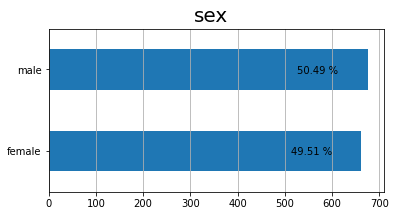

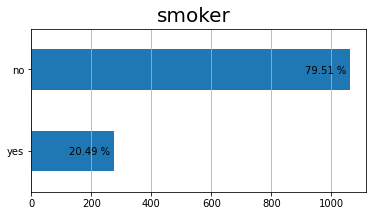

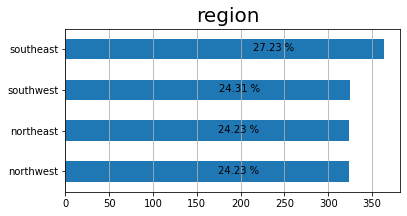

In [ ]:
#@title ### Data columns distributions (categorical type)
list_object = df.select_dtypes(include='O').columns.values.tolist()

for item in list_object:
  df[item].value_counts()
  ax = df[item].value_counts().sort_values().plot(kind='barh',figsize=(6, 3))
  totals = []

  for i in ax.patches:
    totals.append(i.get_width())
    total = sum(totals)

  for i in ax.patches:
    ax.text(i.get_width() - 150, i.get_y() + .2,
            str(round((i.get_width() / total) * 100, 2)) + ' %',
            fontsize=10,
            color='black')
    
  ax.grid(axis='x')
  plt.suptitle(item, fontsize=20)
  plt.show()

### Correlation in data

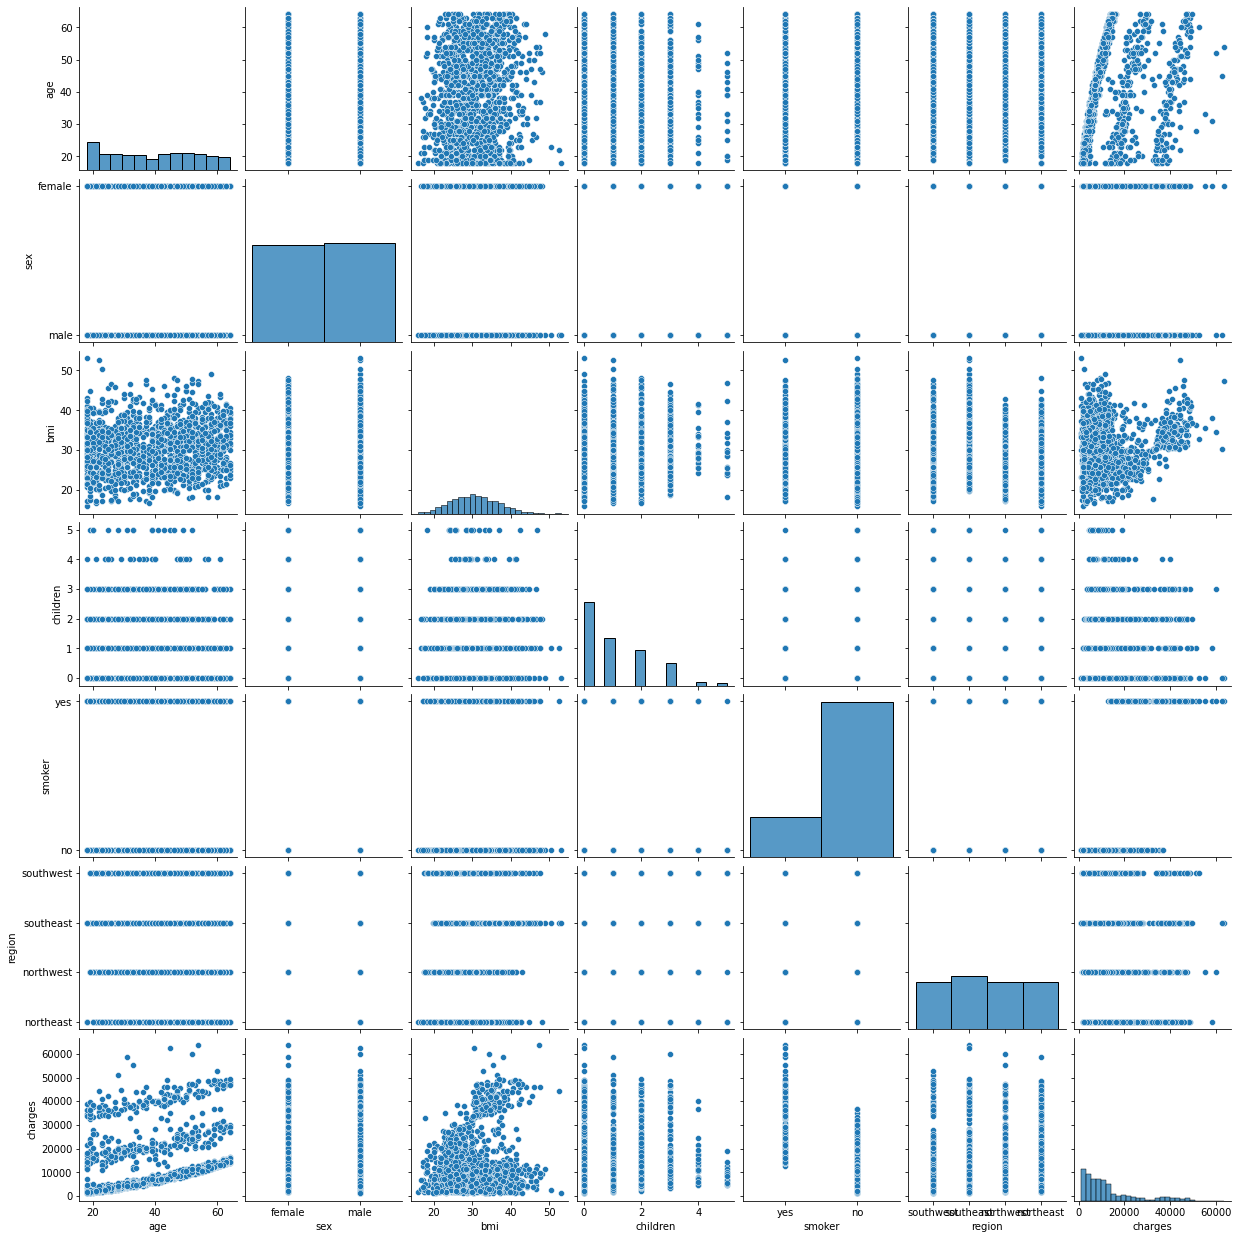

In [ ]:
#@title #### Overall (numerical and categorical)
sns.pairplot(df, vars=['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'])
plt.show()

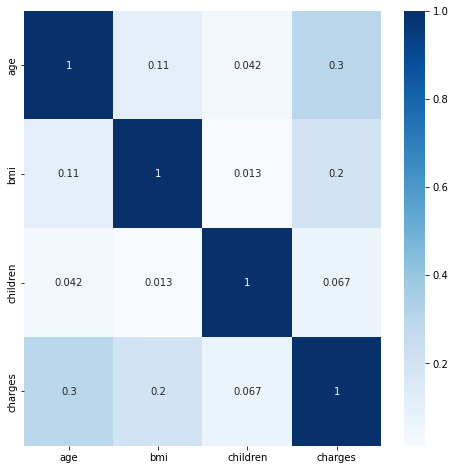

In [ ]:
#@title #### Heatmap for numerical data
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(df.corr(), annot=True, cmap='Blues', cbar=True)
plt.show()

#### Correlation between the target variable and the categorical variables

In [ ]:
#@title 
def plot_bi_uni(cat, num):
  df[cat] = df[cat].replace([np.nan], 'None')
  fig, ax = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize=(25,10))
  fig.suptitle(cat + "   vs   " + num, fontsize=20)
              
  ### distribution
  ax[0].title.set_text('density')
  for i in df[cat].unique():
    sns.distplot(df[df[cat]==i][num], hist=False, label=i, ax=ax[0])
  ax[0].legend()
  ax[0].grid(True)

  ### stacked
  ax[1].title.set_text('bins')
  breaks = np.quantile(df[num], q=np.linspace(0,1,11))
  tmp = df.groupby([cat, pd.cut(df[num], breaks, duplicates='drop')]).size().unstack().T
  tmp = tmp[df[cat].unique()]
  tmp["tot"] = tmp.sum(axis=1)
  for col in tmp.drop("tot", axis=1).columns:
    tmp[col] = tmp[col] / tmp["tot"]
  tmp.drop("tot", axis=1).plot(kind='bar', stacked=True, ax=ax[1], legend=False, grid=True)

  ### boxplot   
  ax[2].title.set_text('outliers')
  sns.boxplot(x=cat, y=num, data=df, ax=ax[2])
  ax[2].grid(True)
  ax[3] = df[cat].value_counts().sort_values().plot(kind="barh", width = 0.3,)

  totals = []
  for i in ax[3].patches:
      totals.append(i.get_width())

  total = sum(totals)
  for i in ax[3].patches:
      ax[3].text(i.get_width() + .3, i.get_y() + .20, 
      str(round((i.get_width() / total) * 100, 2)) + '%', 
      fontsize=10, color='black')

  # ax[3].grid(axis=cat)
  plt.suptitle(cat, fontsize=20)
  
  return plt.show()

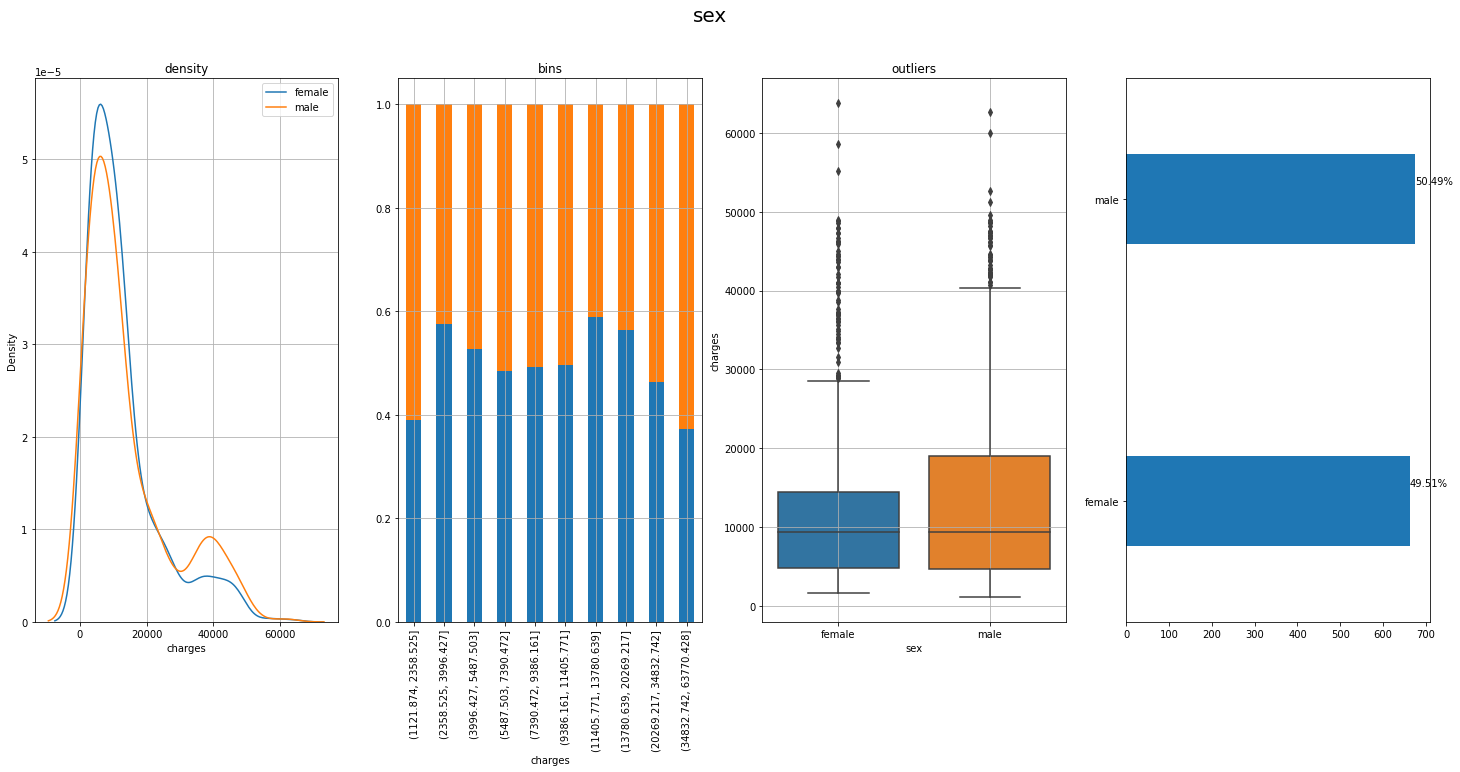

ANOVA test
p-value: 0.034
Conclusion: charges and sex are correlated!


In [ ]:
#@title ##### Correlation between 'charges' variable and 'sex' variable 
cat, num = "sex", "charges"
plot_bi_uni(cat, num)

category_group_list = df.groupby(cat)[num].apply(list)
anova_results = f_oneway(*category_group_list)

print('ANOVA test')
print('p-value:', round(anova_results[1], 3))
if round(anova_results[1], 3) < .05:
    print(f"Conclusion: {num} and {cat} are correlated!")
else:
    print(f"Conclusion: {num} and {cat} are NOT correlated")

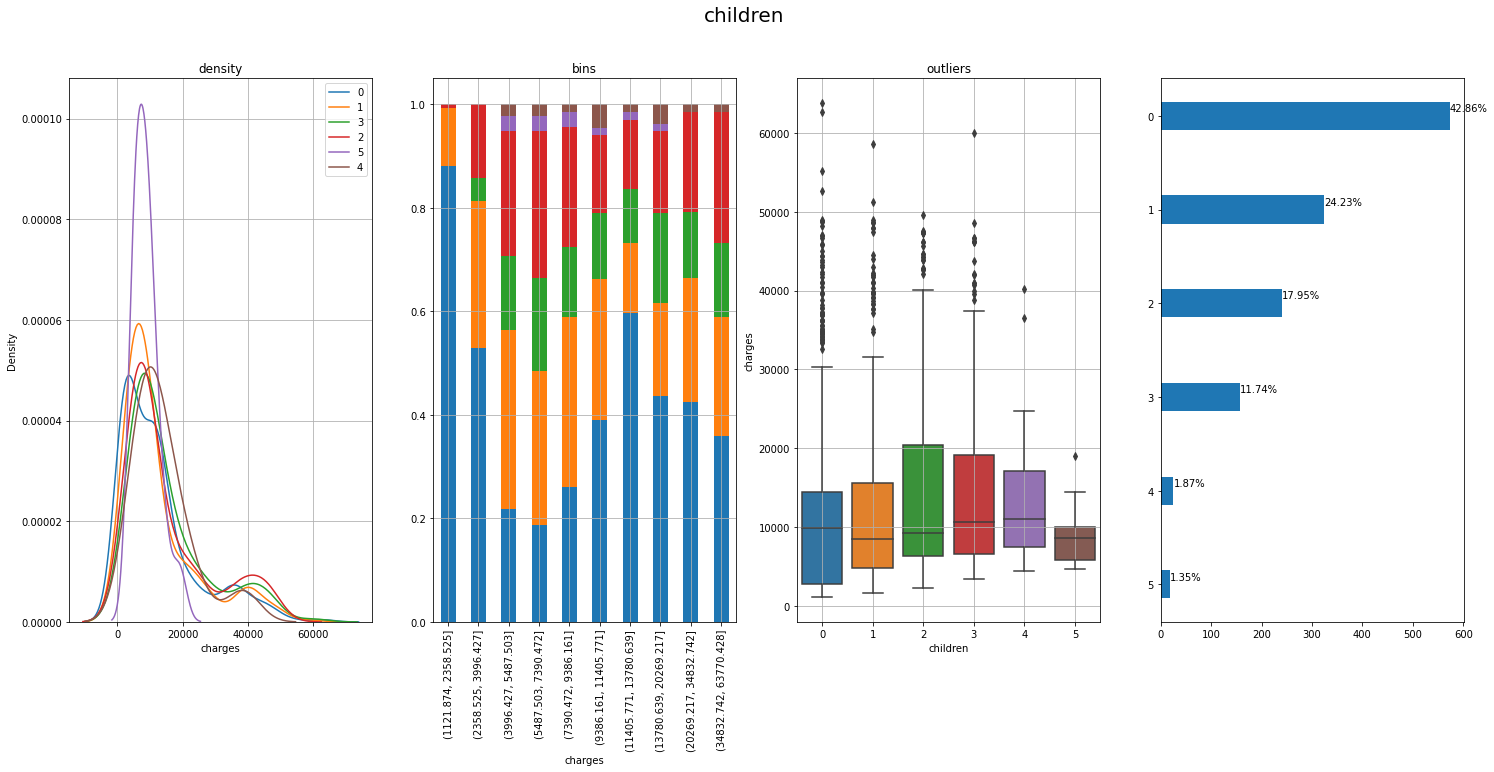

ANOVA test
p-value: 0.006
Conclusion: charges and children are correlated!


In [ ]:
#@title ##### Correlation between 'charges' variable and 'children' variable 
cat, num = "children", "charges"
plot_bi_uni(cat, num)

category_group_list = df.groupby(cat)[num].apply(list)
anova_results = f_oneway(*category_group_list)

print('ANOVA test')
print('p-value:', round(anova_results[1], 3))
if round(anova_results[1], 3) < .05:
    print(f"Conclusion: {num} and {cat} are correlated!")
else:
    print(f"Conclusion: {num} and {cat} are NOT correlated")

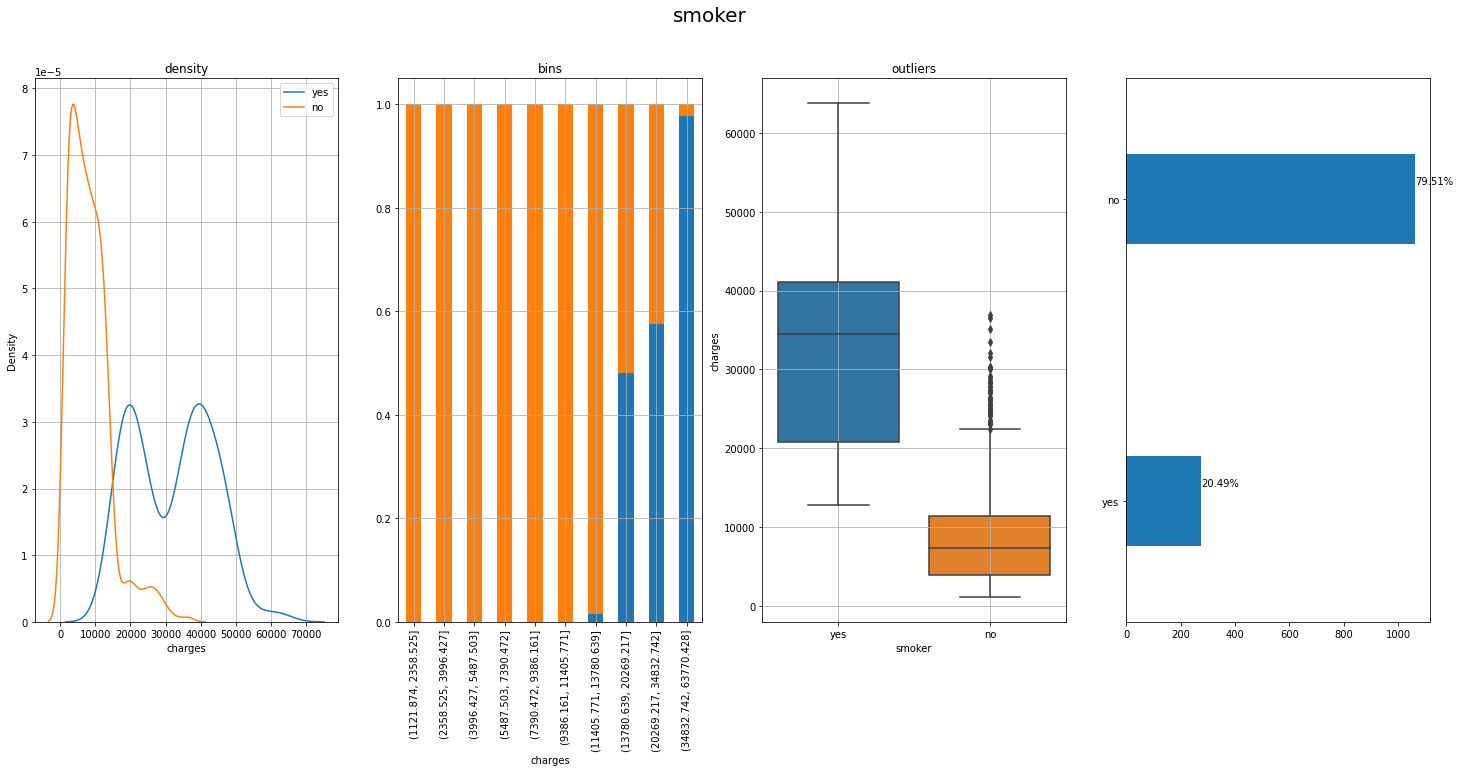

ANOVA test
p-value: 0.0
Conclusion: charges and smoker are correlated!


In [ ]:
#@title ##### Correlation between 'charges' variable and 'smoker' variable 
cat, num = "smoker", "charges"
plot_bi_uni(cat, num)

category_group_list = df.groupby(cat)[num].apply(list)
anova_results = f_oneway(*category_group_list)

print('ANOVA test')
print('p-value:', round(anova_results[1], 3))
if round(anova_results[1], 3) < .05:
    print(f"Conclusion: {num} and {cat} are correlated!")
else:
    print(f"Conclusion: {num} and {cat} are NOT correlated")

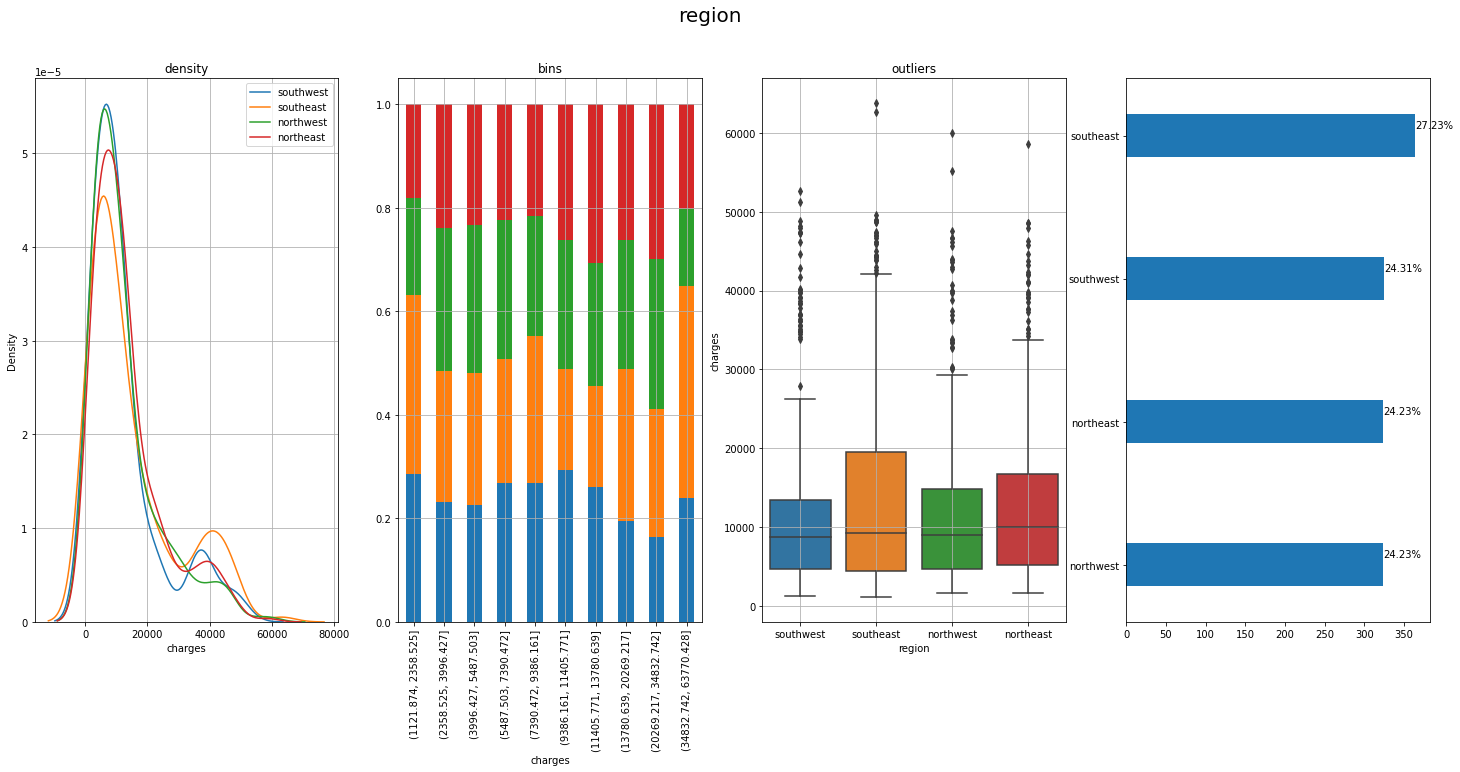

ANOVA test
p-value: 0.033
Conclusion: charges and region are correlated!


In [ ]:
#@title ##### Correlation between 'charges' variable and 'region' variable 
cat, num = "region", "charges"
plot_bi_uni(cat, num)

category_group_list = df.groupby(cat)[num].apply(list)
anova_results = f_oneway(*category_group_list)

print('ANOVA test')
print('p-value:', round(anova_results[1], 3))
if round(anova_results[1], 3) < .05:
    print(f"Conclusion: {num} and {cat} are correlated!")
else:
    print(f"Conclusion: {num} and {cat} are NOT correlated")

## Model

### Transformation of features and target variable

In [ ]:
#@title #### Converting categorical variables to numerical (one hot encoding)
categorical_columns = ['sex', 'children', 'smoker', 'region']
  
df_ohe = pd.get_dummies(df, prefix='OHE', prefix_sep='_',
                columns = categorical_columns,
                drop_first =True,
                dtype='int8')

# df_ohe.head() 

In [ ]:
#@title #### Train and test datasets
X = df_ohe.drop('charges', axis=1)
y = df_ohe['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=404)

In [ ]:
#@title #### Scaling of features (standard scaler)
scaler = preprocessing.StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

In [ ]:
#@title #### Transforming (polynomial converter) and scaling of features (standard scaler)
poly_converter = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly_converter.fit_transform(X_train)
X_test_poly = poly_converter.transform(X_test)

scaler_poly = preprocessing.StandardScaler()
X_train_poly_sc = scaler_poly.fit_transform(X_train_poly)
X_test_poly_sc = scaler_poly.transform(X_test_poly)

In [ ]:
#@title #### Transforming of target variable (Box-Cox transformation)
y_train_bc = stats.boxcox(y_train)[0]

### Regression

N.B.: Linear Regression, Ridge Regression, Lasso Regression and Elastic Net models will be used. Only the model that performs the best will be validated on the test set.

In [ ]:
#@title #### Linear Regression was used on train and test features scaled with standard scaler
LR = LinearRegression()
parameters = {'fit_intercept': [True, False]}
BestLR = GridSearchCV(LR, parameters, scoring='neg_mean_squared_error', cv=5)
BestLR.fit(X_train_sc, y_train)

Best_LR_r2 = r2_score(y_train, BestLR.predict(X_train_sc))
print(f"Scikit-learn LR R2: {Best_LR_r2:.5f}")

Scikit-learn LR R2: 0.74365


In [ ]:
#@title #### Linear Regression was used on train features converted using polynomial converter
BestLR_poly = LinearRegression()
BestLR_poly.fit(X_train_poly_sc, y_train)

BestLR_poly_r2 = r2_score(y_train, BestLR_poly.predict(X_train_poly_sc))
print(f"BestLR_poly R2: {BestLR_poly_r2:.5f}")

BestLR_poly R2: 0.84441


In [ ]:
#@title #### Linear Regression was used on train features converted using polynomial converter and the target variable transformed using Box-Cox
BestLR_poly_bc = LinearRegression()
BestLR_poly_bc.fit(X_train_poly_sc, y_train_bc)
lam = stats.boxcox(y_train)[1]
# inv_predictions = inv_boxcox(BestLR.predict(X_test_poly_sc), lam)

Best_poly_bc_LR_r2 = r2_score(y_train_bc, BestLR_poly_bc.predict(X_train_poly_sc))
print(f"Linear Regression R2: {Best_poly_bc_LR_r2:.5f}")

Scikit-learn LR R2: 0.84712


Conclusion: Linear Regression gave best results when using polynomial features and Box-Cox transformation of the target.

In [ ]:
#@title #### Ridge Regression model was used on train features scaled with standard scaler
RR = Ridge()
parameters = {'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1], 'tol': [1e-06, 5e-06, 1e-05, 5e-05]}
BestRR = GridSearchCV(RR, parameters, scoring='neg_mean_squared_error', cv=5)
BestRR.fit(X_train_sc, y_train)

Best_RR_r2 = r2_score(y_train, BestRR.predict(X_train_sc))
print(f"Ridge Regression R2: {Best_RR_r2:.5f}")

Scikit-learn RR R2: 0.74365


In [ ]:
#@title #### Ridge Regression model was used on train features converted using polynomial converter
RR = Ridge()
parameters = {'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1], 'tol': [1e-06, 5e-06, 1e-05, 5e-05]}
BestRR_poly = GridSearchCV(RR, parameters, scoring='neg_mean_squared_error', cv=5)
BestRR_poly.fit(X_train_poly_sc, y_train)

Best_RR_poly_r2 = r2_score(y_train, BestRR_poly.predict(X_train_poly_sc))
print(f"Riedge Regression poly R2: {Best_RR_poly_r2:.5f}")

Scikit-learn RR_poly R2: 0.84429


Conclusion: Ridge Regression gives better results if polynomial transformation is used.

In [ ]:
#@title #### Lasso Regression model was used on train features scaled with standard scaler
Lasso_model = Lasso()
parameters = {'alpha': [1e-03, 0.01, 0.1, 0.5, 0.8,1]}
BestL = GridSearchCV(Lasso_model, parameters, cv=4)
BestL.fit(X_train_sc, y_train)

Best_L_r2 = r2_score(y_train, BestL.predict(X_train_sc))
print(f"Lasso Regression R2: {Best_L_r2:.5f}")

Scikit-learn L R2: 0.74365


In [ ]:
#@title #### Lasso Regression model was used on train features converted using polynomial converter
Lasso_model = Lasso()
parameters = {'alpha': [1e-03, 0.01, 0.1, 0.5, 0.8, 1]}
BestL_poly = GridSearchCV(Lasso_model, parameters, cv=4)
BestL_poly.fit(X_train_poly_sc, y_train)

BestL_poly_r2 = r2_score(y_train, BestL_poly.predict(X_train_poly_sc))
print(f"Lasso Regression R2: {BestL_poly_r2:.15f}")

Scikit-learn L R2: 0.844402124382179


Lasso Regression gives better results if polynomial transformation is used.

In [ ]:
#@title #### Elastic Net Regression model was used on train features scaled with standard scaler
EN = ElasticNet()
parameters = {'alpha': [0.1, 1.0, 10, 100, 200], 'max_iter': [1000000], 'l1_ratio': [0.1, 0.04, 0.05, 0.8, 1.]}
BestEN = GridSearchCV(EN, parameters, cv=4)
BestEN.fit(X_train_sc, y_train)

Best_EN_r2 = r2_score(y_train, BestEN.predict(X_train_sc))
print(f"Elastic Net R2: {Best_EN_r2:.5f}")

Scikit-learn EN R2: 0.74233


In [ ]:
#@title #### Elastic Net model was used on train features converted using polynomial converter
EN = ElasticNet()
parameters = {'alpha': [0.1, 1.0, 10, 100, 200], 'max_iter': [1000000], 'l1_ratio': [0.1, 0.04, 0.05, 0.8, 1.]}
BestEN_poly = GridSearchCV(EN, parameters, cv=4)
BestEN_poly.fit(X_train_poly_sc, y_train)

BestEN_poly_r2 = r2_score(y_train, BestEN_poly.predict(X_train_poly_sc))
print(f"Elastic Net poly R2: {BestEN_poly_r2:.5f}")

Scikit-learn EN poly R2: 0.84359


Conclusion: Elastic Net gave best results when using polynomial features.
Prediction on a test set will be performed using this model.

### Testing

In [ ]:
#@title Prediction on test set using Linear regression model with train and test features converted using polynomial converter and the target variable transformed using Box-Cox
predictions = BestLR_poly_bc.predict(X_test_poly_sc)

lam = stats.boxcox(y_train)[1]
inv_predictions = inv_boxcox(BestLR_poly_bc.predict(X_test_poly_sc), lam)

val_r2 = r2_score(y_test, inv_predictions)
print(f"R2: {val_r2:.5f}")

R2: 0.85139


In [ ]:
#@title Features importance
importance = BestLR_poly_bc.coef_
importance = np.sort(importance)
feature_names = poly_converter.get_feature_names_out()

df_importances = pd.DataFrame({"Importance": importance, "Feature": feature_names}).sort_values("Importance", ascending=False)
df_importances = df_importances.set_index('Feature')

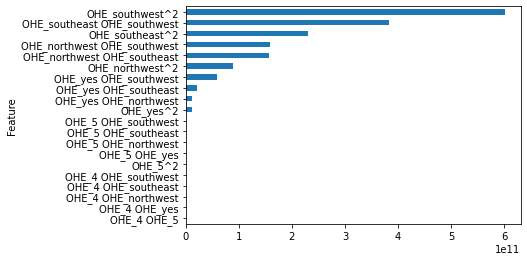

In [ ]:
#@title #### Top 20 polynomial features with positive coefficient in linear regression
df_importances.sort_values(by="Importance").tail(20).plot(kind="barh", legend=False)
plt.show()

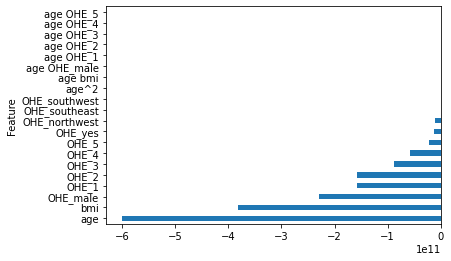

In [ ]:
#@title #### Top 20 polynomial features with negative coefficient in linear regression
df_importances.sort_values(by="Importance").head(20).plot(kind="barh", legend=False)
plt.show()

## Conclusion

The linear regression is giving good predictions using polynomially transformed features and Box-Cox transformation of target. R2 score indicates 85.1 % of explainability of the variance in the data. 

\
The features 'age', 'region' and 'bmi' are the most important for the model prediction.

\
A possible improvement would be to analyse in detail the 'age' feature.

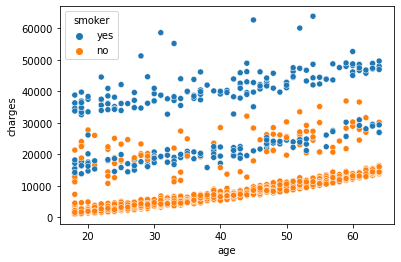

In [ ]:
#@title
sns.scatterplot(x='age', y='charges', hue='smoker', data=df)
plt.show()

Possible solution would be to separate 'charges' in 3 categories and then to have linear or polynomial dependence of the 'charges' on the 'age' feature.